CIFAR-10 dataset found in working directory: /kaggle/working/cifar-10-batches-py
Loading CIFAR-10 data from local directory: /kaggle/working/cifar-10-batches-py
Training samples: 10000
Test samples: 2000
Starting GAN training...
Epoch 0 | G Loss: 0.0533 | D Loss: 0.3044

Starting VAE training...
Epoch 0 | Loss: 263.6927 | Recon: 263.1096 | KL: 0.5830

Could not calculate SSIM scores: 'numpy.ndarray' object has no attribute 'numpy'
Visual comparison available in saved images

Training complete! Displaying results...


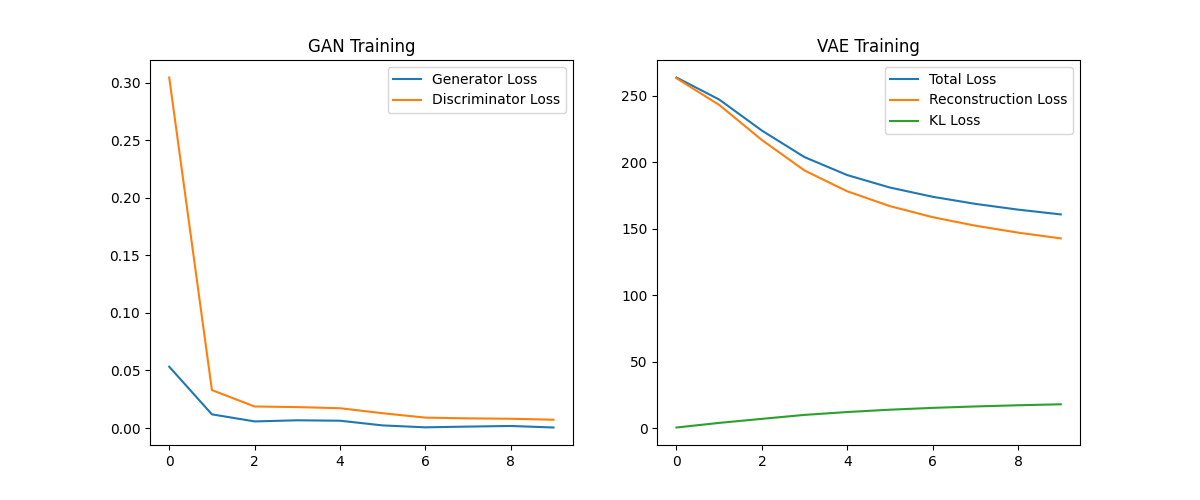

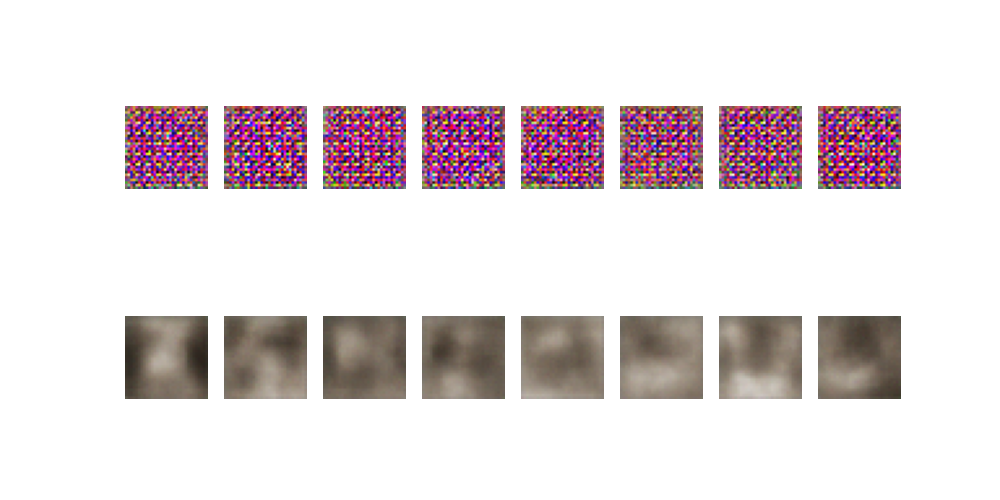

In [5]:
# Image Generation using GAN and VAE on CIFAR-10 (Cats and Dogs)
# Complete Kaggle-ready implementation with fixed dataset loading

import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython.display import display, Image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
import tarfile
from skimage.metrics import structural_similarity as ssim

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configuration
IMG_SHAPE = (32, 32, 3)
BATCH_SIZE = 128
LATENT_DIM = 128
EPOCHS = 10  # Reduced for Kaggle
LEARNING_RATE = 0.0002
BETA_1 = 0.5

# Kaggle paths
WORK_DIR = '/kaggle/working/'
os.makedirs(f'{WORK_DIR}gan_images', exist_ok=True)
os.makedirs(f'{WORK_DIR}vae_images', exist_ok=True)

# ======================
# Fixed Dataset Loading for Kaggle
# ======================

def load_cifar10_kaggle():
    dataset_dir = '/kaggle/working/cifar-10-batches-py'
    tar_gz_path = '/kaggle/input/cifar10-python/cifar-10-python.tar.gz'

    # Check if dataset is already extracted in working directory
    if os.path.exists(dataset_dir) and os.path.isdir(dataset_dir):
        print(f"CIFAR-10 dataset found in working directory: {dataset_dir}")
    elif os.path.exists(tar_gz_path):
        print(f"Extracting CIFAR-10 dataset from: {tar_gz_path} to {WORK_DIR}")
        with tarfile.open(tar_gz_path, 'r:gz') as tar:
            tar.extractall(WORK_DIR)
        print("CIFAR-10 dataset extracted.")
    else:
        print("Downloading CIFAR-10 dataset from online source...")
        from tensorflow.keras.datasets import cifar10
        return cifar10.load_data()

    # Load data from extracted files in working directory
    if os.path.exists(dataset_dir) and os.path.isdir(dataset_dir):
        print(f"Loading CIFAR-10 data from local directory: {dataset_dir}")
        import pickle
        def load_batch(filename):
            filepath = os.path.join(dataset_dir, filename)
            with open(filepath, 'rb') as f:
                batch = pickle.load(f, encoding='bytes')
                data = batch[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
                labels = np.array(batch[b'labels'])
            return data, labels

        x_train_list = []
        y_train_list = []
        for i in range(1, 6):
            data_batch, labels_batch = load_batch(f'data_batch_{i}')
            x_train_list.append(data_batch)
            y_train_list.append(labels_batch)
        x_train = np.concatenate(x_train_list)
        y_train = np.concatenate(y_train_list)

        x_test, y_test = load_batch('test_batch')
        return (x_train, y_train.reshape(-1, 1)), (x_test, y_test.reshape(-1, 1))
    else:
        raise Exception("CIFAR-10 dataset loading failed.")

# Load and filter CIFAR-10 (cats and dogs only)
(x_train, y_train), (x_test, y_test) = load_cifar10_kaggle()
train_mask = ((y_train == 3) | (y_train == 5)).squeeze()
test_mask = ((y_test == 3) | (y_test == 5)).squeeze()
x_train, y_train = x_train[train_mask], y_train[train_mask]
x_test, y_test = x_test[test_mask], y_test[test_mask]

# Normalize to [-1, 1]
x_train = (x_train.astype('float32') / 127.5) - 1.0
x_test = (x_test.astype('float32') / 127.5) - 1.0

# Create dataset pipeline
train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_dataset = train_dataset.shuffle(1000).batch(BATCH_SIZE)

print(f"Training samples: {x_train.shape[0]}")
print(f"Test samples: {x_test.shape[0]}")

# ======================
# Custom GAN Implementation
# ======================

class MinibatchDiscrimination(layers.Layer):
    def __init__(self, num_kernels=30, kernel_dim=5):
        super(MinibatchDiscrimination, self).__init__()
        self.num_kernels = num_kernels
        self.kernel_dim = kernel_dim

    def build(self, input_shape):
        input_dim = input_shape[1]
        self.T = self.add_weight(
            shape=[input_dim, self.num_kernels * self.kernel_dim],
            initializer='glorot_normal',
            name='minibatch_discrim_kernel',
            trainable=True
        )

    def call(self, x):
        M = tf.matmul(x, self.T)
        M = tf.reshape(M, [-1, self.num_kernels, self.kernel_dim])
        M_diff = tf.expand_dims(M, 0) - tf.expand_dims(M, 1)
        abs_diff = tf.reduce_sum(tf.abs(M_diff), axis=-1)
        minibatch_feat = tf.reduce_sum(tf.exp(-abs_diff), axis=1)
        return tf.concat([x, minibatch_feat], axis=1)

def build_generator(latent_dim):
    return keras.Sequential([
        layers.Dense(4*4*256, input_dim=latent_dim),
        layers.Reshape((4, 4, 256)),
        layers.Conv2DTranspose(128, 4, strides=2, padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(64, 4, strides=2, padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(32, 4, strides=2, padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        layers.Conv2D(3, 3, padding='same', activation='tanh')
    ])

def build_siamese_discriminator(input_shape):
    base_model = keras.Sequential([
        layers.Conv2D(32, 3, strides=2, padding='same', input_shape=input_shape),
        layers.LeakyReLU(0.2),
        layers.Conv2D(64, 3, strides=2, padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        layers.Conv2D(128, 3, strides=2, padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        layers.Conv2D(256, 3, padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        layers.GlobalAveragePooling2D()
    ])
    
    base_model.build(input_shape=(None, *input_shape))
    feature_dim = base_model.output_shape[-1]
    
    minibatch_discrim = keras.Sequential([
        layers.Dense(256),
        MinibatchDiscrimination(num_kernels=30, kernel_dim=5)
    ])
    
    input_a = layers.Input(shape=input_shape)
    input_b = layers.Input(shape=input_shape)
    
    features_a = base_model(input_a)
    features_b = base_model(input_b)
    
    features_a = minibatch_discrim(features_a)
    features_b = minibatch_discrim(features_b)
    
    l1_distance = layers.Lambda(lambda x: K.abs(x[0] - x[1]))([features_a, features_b])
    x = layers.Dense(128, kernel_initializer='he_normal')(l1_distance)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.2)(x)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    return Model(inputs=[input_a, input_b], outputs=output)

# Initialize models
generator = build_generator(LATENT_DIM)
discriminator = build_siamese_discriminator(IMG_SHAPE)

# Optimizers
g_optimizer = keras.optimizers.Adam(LEARNING_RATE, beta_1=BETA_1)
d_optimizer = keras.optimizers.Adam(LEARNING_RATE, beta_1=BETA_1)

# Loss function
cross_entropy = keras.losses.BinaryCrossentropy()

def generator_loss(fake_score):
    return cross_entropy(tf.zeros_like(fake_score), fake_score)

def discriminator_loss(real_score, fake_score):
    real_loss = cross_entropy(tf.ones_like(real_score), real_score)
    fake_loss = cross_entropy(tf.zeros_like(fake_score), fake_score)
    return real_loss + fake_loss

@tf.function
def train_step(real_images):
    noise = tf.random.normal([real_images.shape[0], LATENT_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        idx = tf.random.shuffle(tf.range(real_images.shape[0]))
        real_images_shuffled = tf.gather(real_images, idx)

        real_output = discriminator([real_images, real_images_shuffled], training=True)
        fake_output = discriminator([real_images, generated_images], training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    g_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    d_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    g_optimizer.apply_gradients(zip(g_gradients, generator.trainable_variables))
    d_optimizer.apply_gradients(zip(d_gradients, discriminator.trainable_variables))

    return gen_loss, disc_loss

def generate_and_save_images(model, epoch, test_input, model_type='gan'):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow((predictions[i] + 1)/2)
        plt.axis('off')
    plt.savefig(f'{WORK_DIR}{model_type}_images/epoch_{epoch:04d}.png')
    plt.close()

# ======================
# Training Loop
# ======================

def train_gan(dataset, epochs):
    fixed_noise = tf.random.normal([16, LATENT_DIM])
    gen_losses, disc_losses = [], []

    for epoch in range(epochs):
        epoch_gen_loss, epoch_disc_loss = 0, 0
        num_batches = 0

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            epoch_gen_loss += gen_loss
            epoch_disc_loss += disc_loss
            num_batches += 1

        epoch_gen_loss /= num_batches
        epoch_disc_loss /= num_batches
        gen_losses.append(epoch_gen_loss)
        disc_losses.append(epoch_disc_loss)

        if epoch % 10 == 0:
            generate_and_save_images(generator, epoch, fixed_noise)
            print(f"Epoch {epoch} | G Loss: {epoch_gen_loss:.4f} | D Loss: {epoch_disc_loss:.4f}")

        if epoch % 20 == 0:
            generator.save(f'{WORK_DIR}gan_generator.h5')
            discriminator.save(f'{WORK_DIR}gan_discriminator.h5')

    return gen_losses, disc_losses

# ======================
# VAE Implementation
# ======================

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Encoder
encoder_inputs = keras.Input(shape=IMG_SHAPE)
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
z_mean = layers.Dense(LATENT_DIM, name="z_mean")(x)
z_log_var = layers.Dense(LATENT_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# Decoder
latent_inputs = keras.Input(shape=(LATENT_DIM,))
x = layers.Dense(8*8*64, activation="relu")(latent_inputs)
x = layers.Reshape((8,8,64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="tanh", padding="same")(x)
decoder = Model(latent_inputs, decoder_outputs, name="decoder")

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(keras.losses.MSE(data, reconstruction), axis=(1,2)))
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
        
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(LEARNING_RATE))

def train_vae(dataset, epochs):
    fixed_latent = tf.random.normal([16, LATENT_DIM])
    losses, recon_losses, kl_losses = [], [], []

    for epoch in range(epochs):
        epoch_loss, epoch_recon, epoch_kl = 0, 0, 0
        num_batches = 0

        for image_batch in dataset:
            loss_dict = vae.train_step(image_batch)
            epoch_loss += loss_dict['loss']
            epoch_recon += loss_dict['reconstruction_loss']
            epoch_kl += loss_dict['kl_loss']
            num_batches += 1

        losses.append(epoch_loss/num_batches)
        recon_losses.append(epoch_recon/num_batches)
        kl_losses.append(epoch_kl/num_batches)

        if epoch % 10 == 0:
            generate_and_save_images(decoder, epoch, fixed_latent, 'vae')
            print(f"Epoch {epoch} | Loss: {epoch_loss/num_batches:.4f} | Recon: {epoch_recon/num_batches:.4f} | KL: {epoch_kl/num_batches:.4f}")

        if epoch % 20 == 0:
            encoder.save(f'{WORK_DIR}vae_encoder.h5')
            decoder.save(f'{WORK_DIR}vae_decoder.h5')
            vae.save_weights(f'{WORK_DIR}vae.weights.h5')

    return losses, recon_losses, kl_losses

# ======================
# Main Training
# ======================

print("Starting GAN training...")
gan_gen_losses, gan_disc_losses = train_gan(train_dataset, EPOCHS)

print("\nStarting VAE training...")
vae_losses, vae_recon_losses, vae_kl_losses = train_vae(train_dataset, EPOCHS)

# ======================
# Evaluation and Visualization
# ======================

# Plot training curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(gan_gen_losses, label='Generator Loss')
plt.plot(gan_disc_losses, label='Discriminator Loss')
plt.title('GAN Training')
plt.legend()

plt.subplot(1,2,2)
plt.plot(vae_losses, label='Total Loss')
plt.plot(vae_recon_losses, label='Reconstruction Loss')
plt.plot(vae_kl_losses, label='KL Loss')
plt.title('VAE Training')
plt.legend()
plt.savefig(f'{WORK_DIR}training_curves.png')
plt.close()

# Generate comparison images
gan_noise = tf.random.normal([8, LATENT_DIM])
gan_images = generator(gan_noise)
vae_noise = tf.random.normal([8, LATENT_DIM])
vae_images = decoder(vae_noise)

plt.figure(figsize=(10,5))
for i in range(8):
    plt.subplot(2,8,i+1)
    plt.imshow((gan_images[i]+1)/2)
    plt.axis('off')
    if i == 0: plt.ylabel('GAN')

    plt.subplot(2,8,i+9)
    plt.imshow((vae_images[i]+1)/2)
    plt.axis('off')
    if i == 0: plt.ylabel('VAE')
plt.savefig(f'{WORK_DIR}gan_vae_comparison.png')
plt.close()

# Calculate SSIM scores
def calculate_ssim(real_images, generated_images, num_samples=100):
    # Convert tensors to numpy arrays and scale to [0,1]
    real_images_np = ((real_images[:num_samples] + 1) / 2).numpy()
    generated_images_np = ((generated_images[:num_samples] + 1) / 2).numpy()
    
    ssim_scores = []
    for i in range(num_samples):
        ssim_scores.append(ssim(real_images_np[i], generated_images_np[i], 
                              channel_axis=-1, data_range=1.0))
    return np.mean(ssim_scores)

try:
    # Generate samples and calculate SSIM
    gan_samples = generator(tf.random.normal([100, LATENT_DIM]))
    vae_samples = decoder(tf.random.normal([100, LATENT_DIM]))
    
    gan_ssim = calculate_ssim(x_test, gan_samples)
    vae_ssim = calculate_ssim(x_test, vae_samples)
    print(f"\nSSIM Scores (higher is better):\nGAN: {gan_ssim:.4f}\nVAE: {vae_ssim:.4f}")
except Exception as e:
    print(f"\nCould not calculate SSIM scores: {str(e)}")
    print("Visual comparison available in saved images")

# Save final models
generator.save(f'{WORK_DIR}final_gan_generator.h5')
discriminator.save(f'{WORK_DIR}final_gan_discriminator.h5')
encoder.save(f'{WORK_DIR}final_vae_encoder.h5')
decoder.save(f'{WORK_DIR}final_vae_decoder.h5')
 
# Display results in Kaggle notebook
print("\nTraining complete! Displaying results...")
display(Image(filename=f'{WORK_DIR}training_curves.png'))
display(Image(filename=f'{WORK_DIR}gan_vae_comparison.png'))